# Singular-Instance Targeting Example but with Stubborn Agent

James Yu, 11 May 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar

Without the assumption that $A$ is a symmetric matrix, we have to run comparative statics. First, recall that the objective function in question is:

$$V(x_0, x_1(x_0, r)) = -x_0^\prime Q x_0 - \delta x_1^\prime Q x_1 - \sum_{t = 1}^\infty \delta^{t+1} x_1^\prime (A^t)^\prime Q A^t x_1$$

where $x_1(x_0, r) = \tilde A x_0 + br$, where $\tilde A$ is $A$ but weight-adjusted such that the cumulative row sums of $\tilde A$ and $b$ are 1.

In [2]:
def _x_1(x_0, r, A, B, agent):
    tilde_A = A.copy()
    tilde_A[agent] *= 0.99
    return tilde_A @ x_0 + B * r

In [3]:
def V(x_0, r, delta, A, B, agent):
    Q = (1/2) * np.identity(2)
    x_1 = _x_1(x_0, r, A, B, agent)
    cost = -x_0.T @ Q @ x_0 # first term
    cost += -delta * x_1.T @ Q @ x_1 # second term
    t = 1
    while True:
        A_t = np.linalg.matrix_power(A, t)
        newcost = -delta**(t+1) * x_1.T @ A_t.T @ Q @ A_t @ x_1 # new term
        if np.allclose(newcost, 0):
            break
        # add cost and increment t
        cost += newcost
        t += 1
    return cost.item()

# Some comparative statics

In [4]:
A = np.array([
    [0.99, 0.01],
    [0.5, 0.5]
])

B_0 = np.array([
    [0.01],
    [0.0]
], ndmin = 2)

B_1 = np.array([
    [0.0],
    [0.01]
], ndmin = 2)

x_0 = np.array([[5.0], [-10.0]], ndmin = 2)
V(x_0, 5.0, 0.9, A, B_0, 0)

-238.23231397646546

The objective function is quadratic in $r$. For example:

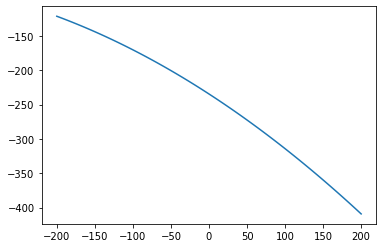

In [5]:
grid = np.linspace(-200, 200, 100)
plt.plot(grid, [V(x_0, r, 0.9, A, B_0, 0) for r in grid])
plt.show()

Therefore a unique extrema must exist.

In [6]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-10.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 66.05321306869209
    nfev: 12
     nit: 5
 success: True
       x: -468.3055121686446

In [7]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-11.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 78.11662686616083
    nfev: 14
     nit: 7
 success: True
       x: -464.9466057689355

In [8]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-12.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 91.46429770225059
    nfev: 13
     nit: 6
 success: True
       x: -461.5877114697964

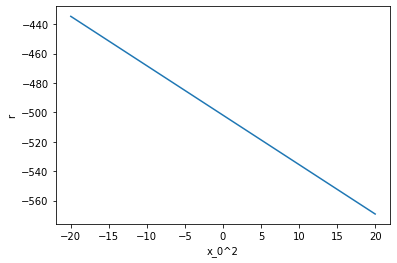

In [9]:
grid = np.linspace(-20, 20, 50)
plt.plot(grid, [minimize_scalar(lambda x: -1 * V(np.array([[5.0], [g]], ndmin = 2), x, 0.9, A, B_0, 0)).x for g in grid])
plt.xlabel("x_0^2")
plt.ylabel("r")
plt.show()

This is linear in $x_0^2$, fixing $x_0^1 = 5$.

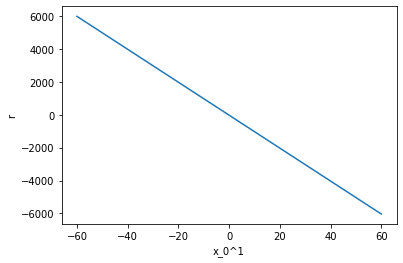

In [35]:
grid = np.linspace(-60, 60, 50)
plt.plot(grid, [minimize_scalar(lambda x: -1 * V(np.array([[g], [5.0]], ndmin = 2), x, 0.9, A, B_0, 0)).x for g in grid])
plt.xlabel("x_0^1")
plt.ylabel("r")
plt.show()

Again, this is linear.

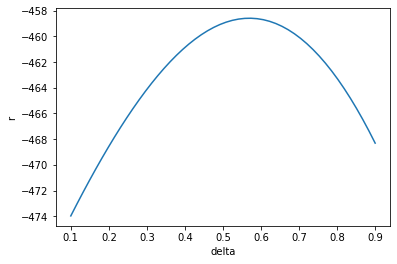

In [11]:
grid = np.linspace(0.1, 0.9, 50)
plt.plot(grid, [minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-10.0]], ndmin = 2), x, delta, A, B_0, 0)).x for delta in grid])
plt.xlabel("delta")
plt.ylabel("r")
plt.show()

This is not linear; we do see that the optimal $r^*$ is increasing in $\delta$ but now there does exist a maximum.

In [12]:
minimize_scalar(lambda x: -1 * V(np.array([[0.0], [0.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: -0.0
    nfev: 10
     nit: 6
 success: True
       x: 0.0

In [13]:
minimize_scalar(lambda x: -1 * V(np.array([[1.0], [0.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 0.642128436538664
    nfev: 12
     nit: 6
 success: True
       x: -100.37898128687617

In [14]:
minimize_scalar(lambda x: -1 * V(np.array([[0.0], [1.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 0.6421284365386634
    nfev: 18
     nit: 12
 success: True
       x: -3.3589813068713363

In [15]:
minimize_scalar(lambda x: -1 * V(np.array([[1.0], [1.0]], ndmin = 2), x, 0.9, A, B_0, 0))

     fun: 1.5685140147265113
    nfev: 13
     nit: 7
 success: True
       x: -103.73783463940417

The change in $r$ (presented as $x$) from a single increase in $x_0^l$ is different between the two agents, which is expected.

# Who is better to target?

In [16]:
print(V(np.array([[5.0], [-10.0]], ndmin = 2), 5.0, 0.9, A, B_0, 0), "target agent 1") # if r = 5
print(V(np.array([[5.0], [-10.0]], ndmin = 2), 5.0, 0.9, A, B_1, 1), "target agent 2")

-238.23231397646546 target agent 1
-238.17174456527178 target agent 2


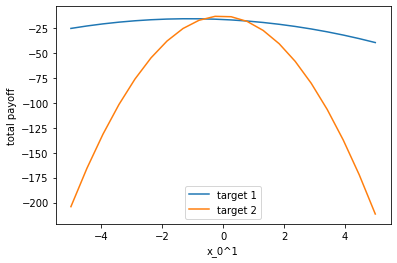

In [17]:
# display the payoffs for using the optimal r at each point
grid = np.linspace(-5, 5, 20)
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[g], [5.0]], ndmin = 2), x, 0.9, A, B_0, 0)).fun for g in grid], label = "target 1")
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[g], [5.0]], ndmin = 2), x, 0.9, A, B_1, 1)).fun for g in grid], label = "target 2")
plt.xlabel("x_0^1")
plt.ylabel("total payoff")
plt.legend()
plt.show()

There is a brief region for $x_0^1$ where it is optimal to target agent 2; otherwise, it is optimal to target agent 1.

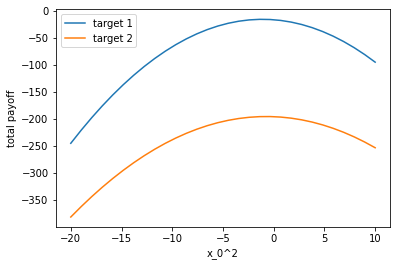

In [18]:
grid = np.linspace(-20, 10, 30)
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[5.0], [g]], ndmin = 2), x, 0.9, A, B_0, 0)).fun for g in grid], label = "target 1")
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[5.0], [g]], ndmin = 2), x, 0.9, A, B_1, 1)).fun for g in grid], label = "target 2")
plt.xlabel("x_0^2")
plt.ylabel("total payoff")
plt.legend()
plt.show()

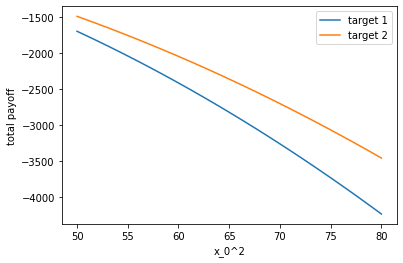

In [19]:
grid = np.linspace(50, 80, 30)
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[5.0], [g]], ndmin = 2), x, 0.9, A, B_0, 0)).fun for g in grid], label = "target 1")
plt.plot(grid, [-1 * minimize_scalar(lambda x: -1 * V(np.array([[5.0], [g]], ndmin = 2), x, 0.9, A, B_1, 1)).fun for g in grid], label = "target 2")
plt.xlabel("x_0^2")
plt.ylabel("total payoff")
plt.legend()
plt.show()

# Payoffs compared to original targeting model

In [20]:
def get_payoff(A, B, R, x_0, delta): 
    Q = (1/2) * np.identity(2)
    K_t = Q
    K_sequence = [Q]
    while True:
        K_t_new = delta * A.T @ (K_t - K_t @ B @ np.linalg.inv(B.T @ K_t @ B + R / delta) @ B.T @ K_t) @ A + Q
        K_sequence.insert(0, K_t_new)
        if np.allclose(K_t, K_t_new, atol = np.finfo(np.float32).eps):
            break
        K_t = K_t_new

    x_t = x_0
    r_ts = []
    payoff = 0
    payoffs = []
    x_ts = [x_0]
    i = 0
    while True:
        L = -(np.linalg.inv(B.T @ K_sequence[0] @ B + R / delta) @ B.T @ K_sequence[0] @ A)
        r_t = L @ x_t
        r_ts.append(r_t.item())
        payoff += (-1 * delta**i * (x_t.T @ Q @ x_t)).item() + (-1 * delta**i * (R * r_t**2)).item()
        payoffs.append(payoff)
        x_t_new = A @ x_t + B @ r_t
        x_ts.append(x_t_new)
        if np.allclose(x_t, x_t_new, atol = np.finfo(np.float32).eps):
            break
        x_t = x_t_new
        i += 1
        
    return payoff, payoffs, x_ts

### A default case: $\delta = 0.9$, target agent 1:

In [21]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-10.0]], ndmin = 2), x, 0.9, A, B_0, 0)).fun * -1

-66.05321306869209

In [22]:
payoff, payoffs, x_ts = get_payoff(A, B_0, 0, np.array([[5.0], [-10.0]], ndmin = 2), 0.9)
payoff

-65.91616006233185

Payoff is better in the original model.

### Target agent 2:

In [23]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-10.0]], ndmin = 2), x, 0.9, A, B_1, 1)).fun * -1

-237.96782423209083

In [24]:
payoff, payoffs, x_ts = get_payoff(A, B_1, 0, np.array([[5.0], [-10.0]], ndmin = 2), 0.9)
payoff

-151.76644762784218

Still better in the original model.

### Target agent 2 and flip $x_0$:

In [25]:
minimize_scalar(lambda x: -1 * V(np.array([[-10.0], [5.0]], ndmin = 2), x, 0.9, A, B_1, 1)).fun * -1

-786.2464973198064

In [26]:
payoff, payoffs, x_ts = get_payoff(A, B_1, 0, np.array([[-10.0], [5.0]], ndmin = 2), 0.9)
payoff

-430.69444850557284

Once again, better in the original model.

### Default case but $\delta = 0.1$:

In [27]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [-10.0]], ndmin = 2), x, 0.1, A, B_0, 0)).fun * -1

-62.820307858210334

In [28]:
payoff, payoffs, x_ts = get_payoff(A, B_0, 0, np.array([[5.0], [-10.0]], ndmin = 2), 0.1)
payoff

-62.8203076232815

With $\delta = 1$, payoff is still better in the original model but the difference is much less.

### Extreme opinion difference:

In [29]:
minimize_scalar(lambda x: -1 * V(np.array([[500.0], [-1000.0]], ndmin = 2), x, 0.9, A, B_0, 0)).fun * -1

-660532.1316408311

In [30]:
payoff, payoffs, x_ts = get_payoff(A, B_0, 0, np.array([[500.0], [-1000.0]], ndmin = 2), 0.9)
payoff

-659161.6006233187

### Extreme difference, same sign:

In [31]:
minimize_scalar(lambda x: -1 * V(np.array([[500.0], [1000.0]], ndmin = 2), x, 0.9, A, B_0, 0)).fun * -1

-944789.1847682807

In [32]:
payoff, payoffs, x_ts = get_payoff(A, B_0, 0, np.array([[500.0], [1000.0]], ndmin = 2), 0.9)
payoff

-932454.4056098677

### No difference:

In [33]:
minimize_scalar(lambda x: -1 * V(np.array([[5.0], [5.0]], ndmin = 2), x, 0.9, A, B_0, 0)).fun * -1

-39.212852559373964

In [34]:
payoff, payoffs, x_ts = get_payoff(A, B_0, 0, np.array([[5.0], [5.0]], ndmin = 2), 0.9)
payoff

-38.664640249327455